In [42]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import tensorflow as tf
import random
from keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage.io import imread, imshow, imsave

In [1]:
import numpy as np
import imgaug.augmenters as iaa

In [23]:
seq = iaa.Sequential([
    iaa.Crop(px=(1, 16), keep_size=True),
    iaa.Fliplr(),
    iaa.GaussianBlur(sigma=(0, 3.0))
])

<class 'numpy.ndarray'> (9, 450, 450, 3) uint8 (450, 450, 3) uint8


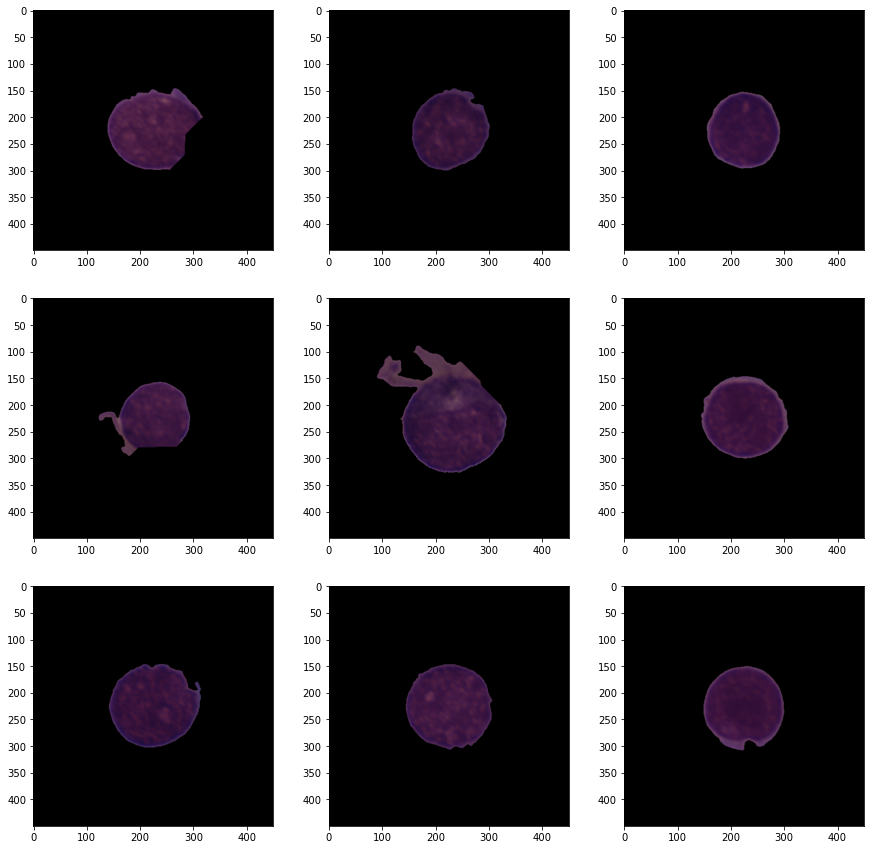

In [71]:
path = r'C:\Users\DIPTO\Desktop\Data\train\hem'

hem_list = os.listdir(path)
hem_list.sort()

batch = np.zeros((9, 450, 450, 3), dtype=np.uint8)

i = 0
for x in hem_list:
    if 0<=i<=8:
        image = imread(os.path.join(path,x))
        batch[i] = image
    else:
        break
    i +=1
        
print(type(batch), batch.shape, batch.dtype, batch[0].shape, batch[0].dtype)

i=0
plt.figure(figsize=(15,15))
for x in batch:
    plt.subplot(3,3,i+1)
    plt.imshow(x)
    i +=1

<class 'numpy.ndarray'> (9, 450, 450, 3) uint8 (450, 450, 3) uint8
40


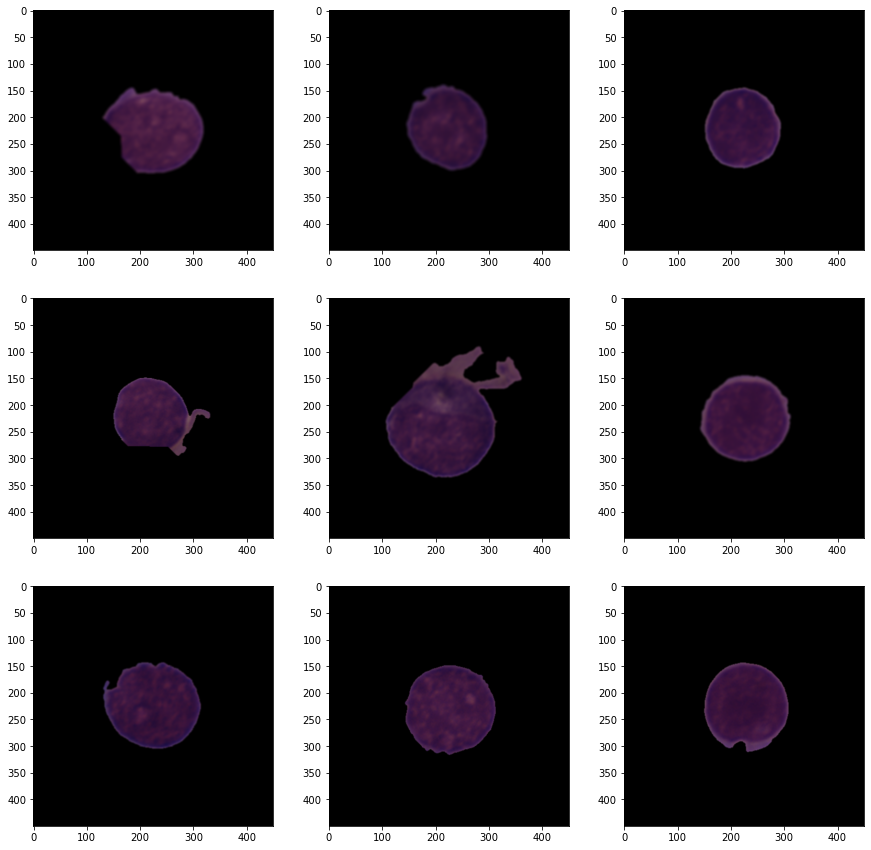

In [72]:
images_aug = seq(images=batch)  # done by the library    

print(type(images_aug), images_aug.shape, images_aug.dtype, images_aug[0].shape, images_aug[0].dtype)

i=0
plt.figure(figsize=(15,15))
for x in images_aug:
    plt.subplot(3,3,i+1)
    plt.imshow(x)
    i +=1
print(len(hem_list))
for x in range(len(hem_list)):
    if x<9:
        path = 'C:/Users/DIPTO/Desktop/Aug_img/' + 'Aug_' +hem_list[x]
        #print(path)
        imsave(path ,images_aug[x])

In [11]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import tensorflow as tf
import random
from keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage.io import imread, imshow, imsave

In [19]:
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

<class 'numpy.ndarray'> (9, 210, 210, 3) uint8 (210, 210, 3) uint8


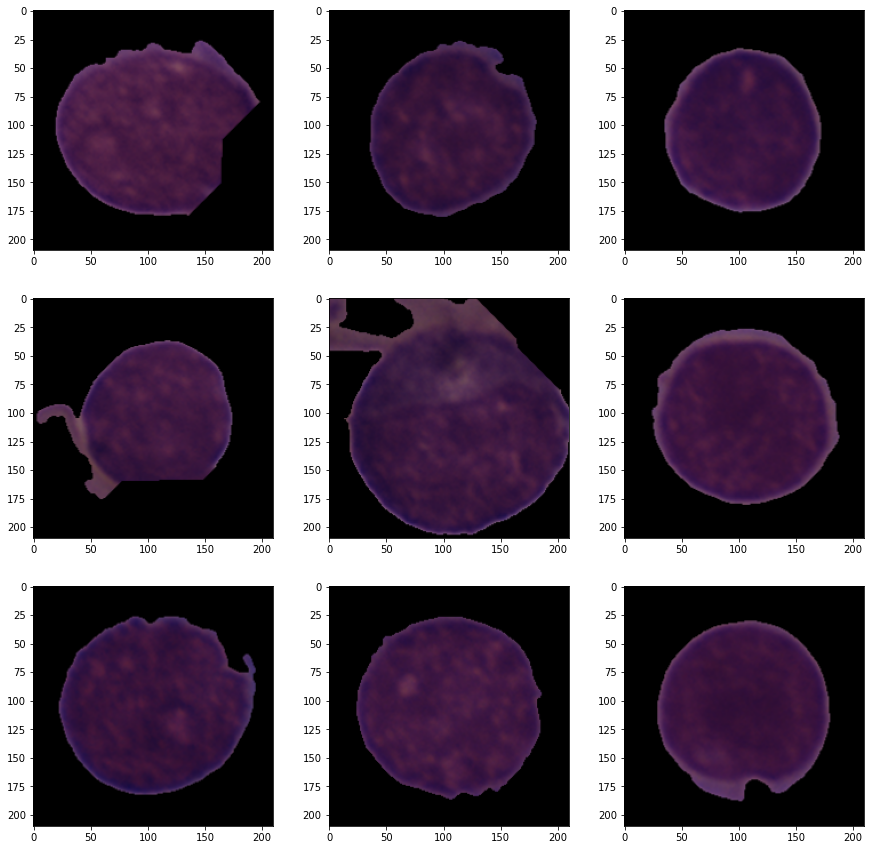

In [21]:
path = r'C:\Users\DIPTO\Desktop\Data\train\hem'

hem_list = os.listdir(path)
hem_list.sort()

batch = np.zeros((9, 210, 210, 3), dtype=np.uint8)

'''Read & Crop Images'''
i = 0
for x in hem_list:
    if 0<=i<=8:
        image = imread(os.path.join(path,x))
        image = cropND(image, (210,210,3))
        batch[i] = image
    else:
        break
    i +=1
        
print(type(batch), batch.shape, batch.dtype, batch[0].shape, batch[0].dtype)

'''Plot Original Images'''
i=0
plt.figure(figsize=(15,15))
for x in batch:
    plt.subplot(3,3,i+1)
    plt.imshow(x)
    i +=1

In [25]:
'''Define Augmentation Pipeline'''

sometimes = lambda aug: iaa.Sometimes(0.5, aug)


seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)


<class 'numpy.ndarray'> (9, 210, 210, 3) uint8 (210, 210, 3) uint8
40


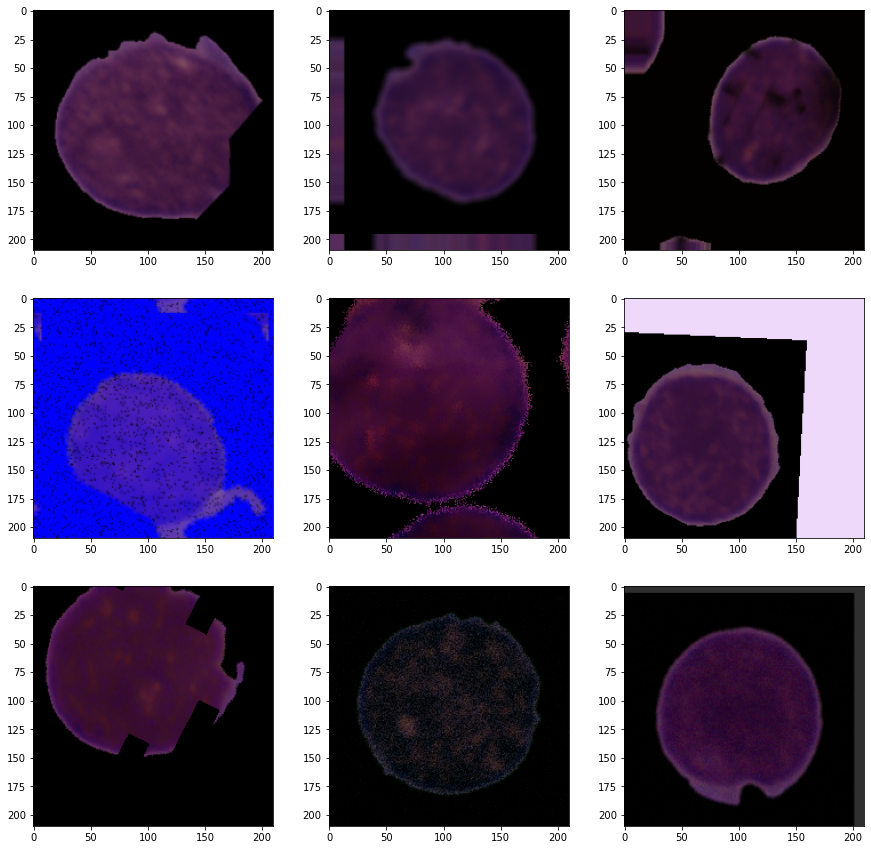

In [30]:
'''Augmentation Done'''
images_aug = seq(images=batch)  # done by the library    

print(type(images_aug), images_aug.shape, images_aug.dtype, images_aug[0].shape, images_aug[0].dtype)

'''Plot Augmented Images'''
i=0
plt.figure(figsize=(15,15))
for x in images_aug:
    plt.subplot(3,3,i+1)
    plt.imshow(x)
    i +=1

print(len(hem_list))

'''Save Augmented Images'''
for x in range(len(hem_list)):
    if x<9:
        path = 'C:/Users/DIPTO/Desktop/Aug_img/' + 'Aug_' +hem_list[x]
        #print(path)
        imsave(path ,images_aug[x])

# Final Code

In [71]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import tensorflow as tf
import random
from keras.preprocessing.image import ImageDataGenerator
import skimage
from skimage.io import imread, imshow, imsave

In [73]:
def crop_center(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [74]:
'''Source Path'''
train_all_path = r'C:\Users\DIPTO\Desktop\Data_oversamp\train\all'
train_hem_path = r'C:\Users\DIPTO\Desktop\Data_oversamp\train\hem'  # augment this

val_all_path = r'C:\Users\DIPTO\Desktop\Data_oversamp\val\all'
val_hem_path = r'C:\Users\DIPTO\Desktop\Data_oversamp\val\hem'     # augment this

In [77]:
train_all_list = os.listdir(train_all_path)
train_all_list.sort()

train_hem_list = os.listdir(train_hem_path)       # augment this
train_hem_list.sort()

val_all_list = os.listdir(val_all_path)
val_all_list.sort()

val_hem_list = os.listdir(val_hem_path)          # augment this
val_hem_list.sort()

print('train/all: ', len(train_all_list))
print('train/hem :', len(train_hem_list))
print('val/all: ', len(val_all_list))
print('val/hem :', len(val_hem_list))

train/all:  100
train/hem : 80
val/all:  50
val/hem : 40


In [78]:
train_all_batch = np.zeros((len(train_all_list), 210, 210, 3), dtype=np.uint8)
train_hem_batch = np.zeros((len(train_hem_list), 210, 210, 3), dtype=np.uint8)    # augment this

val_all_batch = np.zeros((len(val_all_list), 210, 210, 3), dtype=np.uint8)
val_hem_batch = np.zeros((len(val_hem_list), 210, 210, 3), dtype=np.uint8)        # augment this

print(train_all_batch.shape, train_hem_batch.shape)
print(val_all_batch.shape, val_hem_batch.shape)

(100, 210, 210, 3) (80, 210, 210, 3)
(50, 210, 210, 3) (40, 210, 210, 3)


In [67]:
def Read_n_Crop(list_data, batch, path):
    i=0
    for x in list_data:
        image = imread(os.path.join(path, x))
        image = crop_center(image, (210,210,3))
        batch[i] = image
        i+=1
    
    print(type(batch), batch.shape, batch.dtype, batch[0].shape, batch[0].dtype)

In [79]:
Read_n_Crop(train_all_list, train_all_batch, train_all_path)
Read_n_Crop(train_hem_list, train_hem_batch, train_hem_path)      # augment this

Read_n_Crop(val_all_list, val_all_batch, val_all_path)
Read_n_Crop(val_hem_list, val_hem_batch, val_hem_path)           # augment this

<class 'numpy.ndarray'> (100, 210, 210, 3) uint8 (210, 210, 3) uint8
<class 'numpy.ndarray'> (80, 210, 210, 3) uint8 (210, 210, 3) uint8
<class 'numpy.ndarray'> (50, 210, 210, 3) uint8 (210, 210, 3) uint8
<class 'numpy.ndarray'> (40, 210, 210, 3) uint8 (210, 210, 3) uint8


In [69]:
'''Save Oversampled Cropped Images'''
def SaveOC_images(list_data, path, batch):
    for x in range(len(list_data)):
        new_path = path + '/' + list_data[x]
        print(new_path)
        imsave(new_path ,batch[x])

In [80]:
path = 'C:/Users/DIPTO/Desktop/Data2/train/all'
SaveOC_images(train_all_list, path, train_all_batch)
path = 'C:/Users/DIPTO/Desktop/Data2/train/hem'
SaveOC_images(train_hem_list, path, train_hem_batch)     # augment this

path = 'C:/Users/DIPTO/Desktop/Data2/val/all'
SaveOC_images(val_all_list, path, val_all_batch)
path = 'C:/Users/DIPTO/Desktop/Data2/val/hem'
SaveOC_images(val_hem_list, path, val_hem_batch)         # augment this

C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_10_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_10_2_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_10_3_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_10_4_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_11_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_1_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_2_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_2_2_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_3_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_4_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_4_2_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_5_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_6_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_7_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_7_2_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_8_1_all.bmp
C:/Users/DIPTO/Desktop/Data2/train/all/UID_1_8_2_all.bmp
C:/Users/DIPTO/Desktop/Dat

C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_5_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_5_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_6_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_6_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_7_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_7_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_8_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_8_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_9_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H1_9_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H2_1_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H2_1_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H2_1_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H2_1_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H2_1_3_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/UID_H2_1_3_hem.bmp
C:/Users/DIPTO/D

In [31]:
def Plot_images(batch, num):
    i=0
    plt.figure(figsize=(15,15))
    for x in batch:
        if 0<=i<=64:
            plt.subplot(num,num,i+1)
            plt.imshow(x)
        i +=1

ValueError: num must be 1 <= num <= 64, not 65

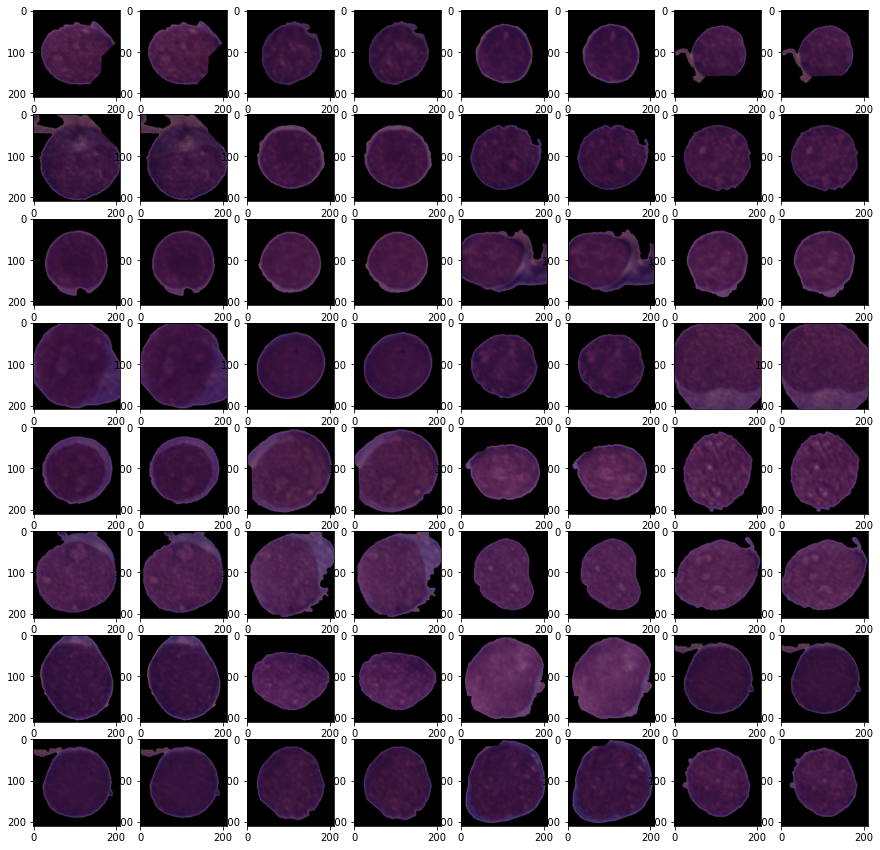

In [81]:
num = 8 # row n col
Plot_images(train_hem_batch, num)

ValueError: num must be 1 <= num <= 25, not 26

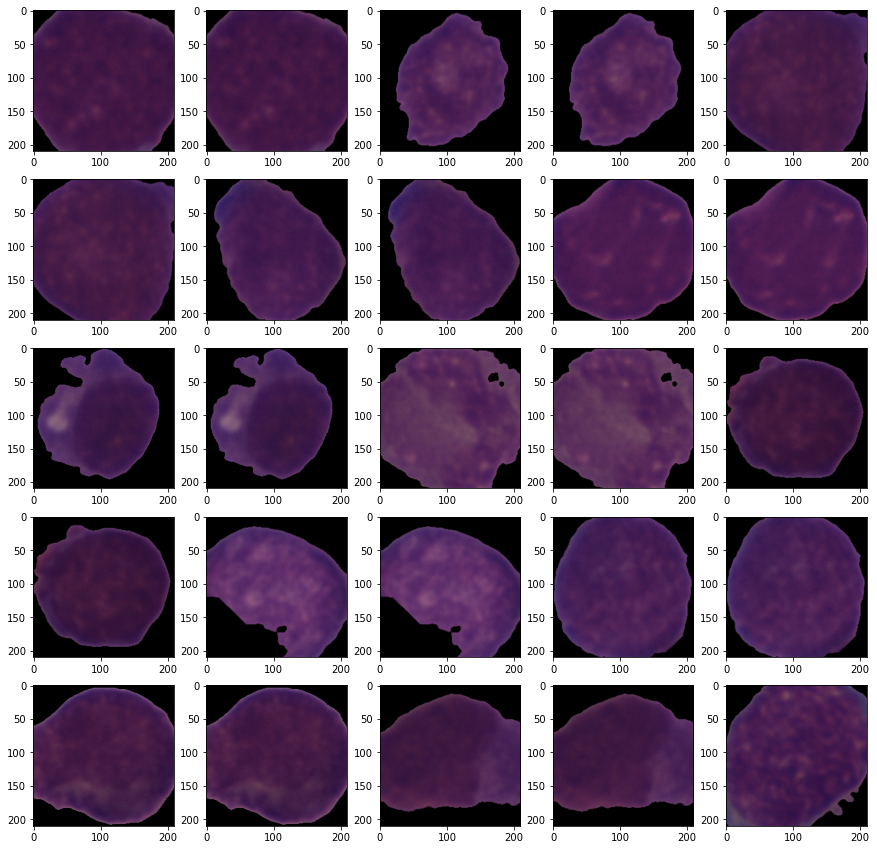

In [82]:
num = 5
Plot_images(val_hem_batch, num)

In [83]:
'''Define Augmentation Pipeline'''

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.BlendAlphaFrequencyNoise(
                        exponent=(-4, 0),
                        foreground=iaa.Multiply((0.5, 1.5), per_channel=True),
                        background=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)


In [96]:
def AugmentNsave_images(seq, batch, list_data, path, n):
    '''Augment'''
    images_aug = seq(images=batch)
    print(type(images_aug), images_aug.shape, images_aug.dtype, np.max(images_aug), np.min(images_aug), images_aug[0].shape, images_aug[0].dtype, np.max(images_aug[0]), np.min(images_aug[0]))
    '''Save'''
    for x in range(len(list_data)):
        #print(path)
        new_path = path + '/' + str(n) + 'Aug_' + list_data[x]
        print(new_path)
        imsave(new_path ,images_aug[x])

In [97]:
'''Each time augmented results are different'''
times2augment = 5
path = 'C:/Users/DIPTO/Desktop/Data2/train/hem'
for x in range(times2augment):
    AugmentNsave_images(seq,train_hem_batch, train_hem_list, path, x+1)
    
path = 'C:/Users/DIPTO/Desktop/Data2/val/hem'
for x in range(times2augment):
    AugmentNsave_images(seq,val_hem_batch, val_hem_list, path, x+1)

<class 'numpy.ndarray'> (80, 210, 210, 3) uint8 255 0 (210, 210, 3) uint8 110 0
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_10_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_10_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_11_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_11_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_15_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_15_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_16_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_16_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_16_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_16_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_19_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_19_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_1_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_29_1_hem.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_2_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_40_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H2_2_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_40_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_44_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_44_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_5_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_5_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_6_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_6_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_7_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_7_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_8_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_8_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_9_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H1_9_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H2_1_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H2_1_1_hem.bmp
C:/

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/1Aug_UID_H2_3_3_hem.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


<class 'numpy.ndarray'> (80, 210, 210, 3) uint8 255 0 (210, 210, 3) uint8 255 0
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_10_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_10_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_11_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_11_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_15_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_15_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_16_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_16_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_16_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_16_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_19_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_19_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_1_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_20_1_hem.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_21_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_27_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_32_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H1_34_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_1_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_1_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_1_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_1_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_1_3_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_1_3_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_2_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_2_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_3_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_3_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_3_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_3_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_3_3_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_3_3_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/2Aug_UID_H2_3_4_hem - Copy.bmp

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H1_1_1_hem.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H1_22_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H1_33_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H1_7_1_hem.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_1_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_1_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_1_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_1_3_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_1_3_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_2_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_2_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_3_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_3_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_4_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/3Aug_UID_H2_3_4_hem.bmp
<class

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H1_16_2_hem.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H1_29_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H1_6_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H1_8_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H1_8_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H1_9_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H1_9_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_1_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_1_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_1_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_1_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_1_3_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_1_3_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_2_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_2_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_3_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_3_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/4Aug_UID_H2_3_2_hem - Copy.bmp

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H1_27_1_hem.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_3_1_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H1_7_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H1_7_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H1_8_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H1_8_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H1_9_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H1_9_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_1_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_1_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_1_2_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_1_2_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_1_3_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_1_3_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_2_1_hem - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_2_1_hem.bmp
C:/Users/DIPTO/Desktop/Data2/train/hem/5Aug_UID_H2_3_1_hem - Copy.bmp

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/1Aug_4 - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


<class 'numpy.ndarray'> (40, 210, 210, 3) uint8 255 0 (210, 210, 3) uint8 106 4
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_13 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_13.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_14 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_14.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_21 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_21.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_24 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_24.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_26 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_26.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_27 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_27.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_28 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_28.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_30 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_30.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_31 - Copy.bmp
C:/Users/DIPTO/Desktop/D

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_35 - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_35.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/2Aug_4 - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


<class 'numpy.ndarray'> (40, 210, 210, 3) uint8 255 0 (210, 210, 3) uint8 15 0
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_13 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_13.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_14 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_14.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_21 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_21.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_24 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_24.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_26 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_26.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_27 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_27.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_28 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_28.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_30 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_30.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_31 - Copy.bmp
C:/Users/DIPTO/Desktop/Da

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_13 - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/3Aug_30.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


<class 'numpy.ndarray'> (40, 210, 210, 3) uint8 255 0 (210, 210, 3) uint8 255 0
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_13 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_13.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_14 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_14.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_21 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_21.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_24 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_24.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_26 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_26.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_27 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_27.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_28 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_28.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_30 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_30.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_31 - Copy.bmp
C:/Users/DIPTO/Desktop/D

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/4Aug_30.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


<class 'numpy.ndarray'> (40, 210, 210, 3) uint8 255 0 (210, 210, 3) uint8 248 0
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_13 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_13.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_14 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_14.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_21 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_21.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_24 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_24.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_26 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_26.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_27 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_27.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_28 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_28.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_30 - Copy.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_30.bmp
C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_31 - Copy.bmp
C:/Users/DIPTO/Desktop/D

<ipython-input-96-331a320b26c9>:10: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/5Aug_8.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


In [76]:
'''Augmentation Done'''
train_hem_images_aug = seq(images=train_hem_batch) 
val_hem_images_aug = seq(images=val_hem_batch)

print(type(train_hem_images_aug), train_hem_images_aug.shape, train_hem_images_aug.dtype, train_hem_images_aug[0].shape, train_hem_images_aug[0].dtype)
print(type(val_hem_images_aug), val_hem_images_aug.shape, val_hem_images_aug.dtype, val_hem_images_aug[0].shape, val_hem_images_aug[0].dtype)

<class 'numpy.ndarray'> (80, 210, 210, 3) uint8 (210, 210, 3) uint8
<class 'numpy.ndarray'> (40, 210, 210, 3) uint8 (210, 210, 3) uint8


ValueError: num must be 1 <= num <= 25, not 26

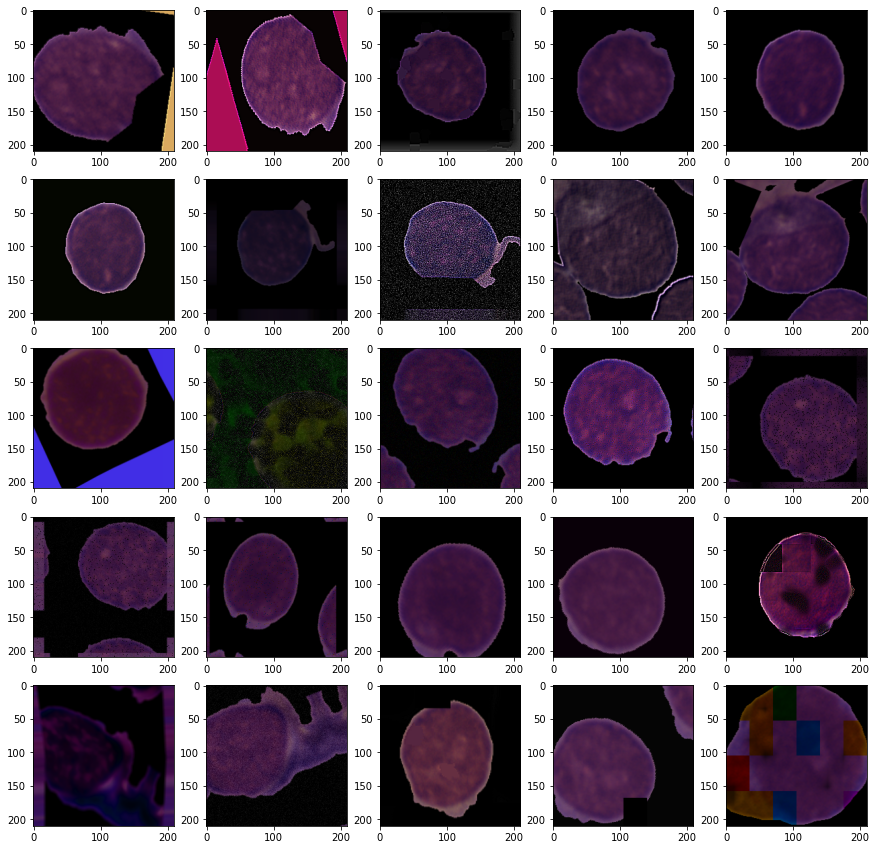

In [77]:
num = 5 # row n col
Plot_images(train_hem_images_aug, num)

ValueError: num must be 1 <= num <= 25, not 26

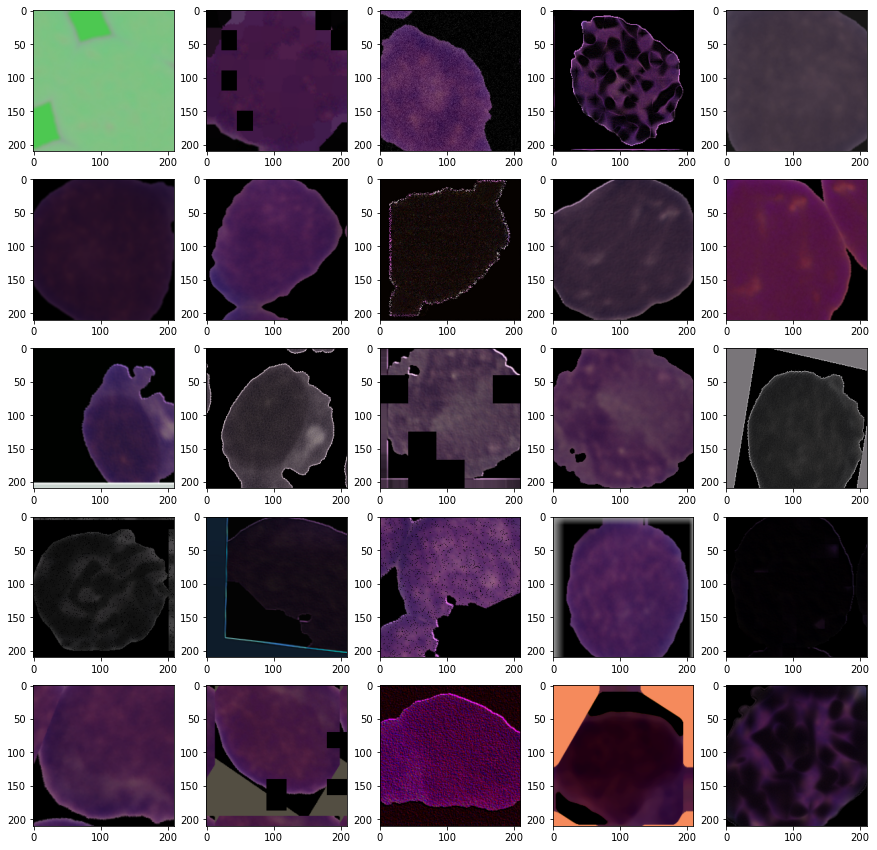

In [78]:
num = 5
Plot_images(val_hem_images_aug, num)

In [83]:
def Save_images(list_data, path, images_aug):
    for x in range(len(list_data)):
        print(path)
        new_path = path + '/Aug_' + list_data[x]
        imsave(new_path ,images_aug[x])

In [84]:
path = 'C:/Users/DIPTO/Desktop/Data2/train/hem'
Save_images(train_hem_list, path, train_hem_images_aug)
path = 'C:/Users/DIPTO/Desktop/Data2/val/hem'
Save_images(val_hem_list, path, val_hem_images_aug)

C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Data2/train/hem
C:/Users/DIPTO/Desktop/Da

<ipython-input-83-16dc5ea79905>:5: UserWarning: C:/Users/DIPTO/Desktop/Data2/train/hem/Aug_UID_H2_1_2_hem - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-83-16dc5ea79905>:5: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/Aug_13 - Copy.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-83-16dc5ea79905>:5: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/Aug_35.bmp is a low contrast image
  imsave(new_path ,images_aug[x])
<ipython-input-83-16dc5ea79905>:5: UserWarning: C:/Users/DIPTO/Desktop/Data2/val/hem/Aug_54.bmp is a low contrast image
  imsave(new_path ,images_aug[x])


C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem
C:/Users/DIPTO/Desktop/Data2/val/hem


SyntaxError: unexpected EOF while parsing (<ipython-input-11-91403fd23518>, line 2)